# Ibis on &#x1F525;: Supercharge Your Workflow with DuckDB and PyTorch

In this blog post we show how to leverage ecosystem tools to build an end-to-end ML pipeline using Ibis, DuckDB and PyTorch.

Check out the live stream of this notebook here: https://www.youtube.com/live/L4_deAdStKs?feature=share

Let's get started!

In [1]:
import ibis
import ibis.expr.datatypes as dt

from ibis import _, selectors as s, udf

In [2]:
ibis.options.interactive = True

## Define a Function to Clean Inputs

Let's define a function to clean the data in a few different ways:

- Remove outliers (Z-score based)
- Remove negative trip distances and negative fare amounts
- Cast inputs to `float32`, since that's what PyTorch wants

We use a function here ito ensure that we can run the same code on the test data set before inference.

In [3]:
def clean_input(path):
    return (
        # load parquet
        ibis.read_parquet(path)
        # compute fare_amount_zscore and trip_distance_zscore
        .mutate(s.across(["fare_amount", "trip_distance"], dict(zscore=(_ - _.mean()) / _.std())))
        # filter out negative trip distance and bizarre transactions
        .filter([_.trip_distance > 0.0, _.fare_amount >= 0.0])
        # keep values that within 2 standard deviations
        .filter(s.if_all(s.endswith("_zscore"), _.abs() <= 2))
        # drop columns that aren't necessary for further analysis
        .drop(s.endswith("_zscore"))
        # select the columns we care about
        .select(s.across(["fare_amount", "trip_distance"], _.cast("float32")))
    )

In [4]:
training_data = clean_input("/home/cloud/data/trip-data/yellow_tripdata_2016-01.parquet")

In [5]:
training_data

┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ trip_distance ┃ fare_amount ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ float32       │ float32     │
├───────────────┼─────────────┤
│          3.20 │        14.0 │
│          1.00 │         9.5 │
│          0.90 │         6.0 │
│          0.80 │         5.0 │
│          1.80 │        11.0 │
│          2.30 │        11.0 │
│         13.80 │        43.0 │
│          3.46 │        20.0 │
│          0.83 │         5.5 │
│          0.87 │         7.0 │
│             … │           … │
└───────────────┴─────────────┘

## Execute the Query and Convert to Torch Tensors

New in Ibis 6.0 is the `to_torch` method, which executes a query and returns the results as a dictionary of `torch.Tensor`s keyed by column names.

We'll use that to get our input data for training.

In [6]:
torch_training_data = training_data.to_torch()  # type: dict[str, Tensor]

In [7]:
torch_training_data

{'trip_distance': tensor([3.2000, 1.0000, 0.9000,  ..., 5.6300, 0.7700, 1.2600]),
 'fare_amount': tensor([14.0000,  9.5000,  6.0000,  ..., 18.5000,  5.0000,  6.5000])}

## Train the Model

Let's assume for now we don't have access to the model code. Maybe your co-worker wrote the model or it's part of an API that you don't control. Either way, it's a black box to us.

The API looks like this:

```python
class PredictCabFare:
    def __init__(self, data: dict[str, torch.Tensor]) -> None:
        """Initialize the model with training data."""

    def train(self) -> None:
        """Train the model."""

    def __call__(self, input: pyarrow.ChunkedArray) -> pyarrow.Array:
        """Invoke the trained model on unseen input."""
```

In [8]:
from model import PredictCabFare


model = PredictCabFare(torch_training_data)
model.train()

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.46it/s]


## Define an Ibis UDF that Runs Inference

Now we get to the meaty part: defining an Ibis UDF (user-defined function) that invokes our model on unseen data!

In [9]:
from ibis.expr.operations import udf


@udf.scalar.pyarrow
def predict_fare(distance: dt.float64) -> dt.float32:
    return model(distance)

In [10]:
## Visualize the comparison between the predicted cab fares and the actual cab fares
prediction = (
    clean_input("/home/cloud/data/trip-data/yellow_tripdata_2016-02.parquet")
    .limit(10_000)
    .mutate(predicted_fare=lambda t: predict_fare(t.trip_distance.cast("float32")))
)
prediction

┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ trip_distance ┃ fare_amount ┃ predicted_fare ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ float32       │ float32     │ float32        │
├───────────────┼─────────────┼────────────────┤
│           9.1 │        27.0 │      29.008099 │
│           3.3 │        11.5 │      12.776804 │
│           0.5 │         4.0 │       4.941007 │
│           7.4 │        26.5 │      24.250650 │
│           1.6 │         7.5 │       8.019356 │
│           3.8 │        16.0 │      14.176053 │
│           1.1 │         6.0 │       6.620107 │
│           6.8 │        21.0 │      22.571550 │
│           2.9 │        12.0 │      11.657405 │
│           1.2 │         6.5 │       6.899957 │
│             … │           … │              … │
└───────────────┴─────────────┴────────────────┘

## Prepare the Data for Plotting

Here we [tidy up our data](https://r4ds.had.co.nz/tidy-data.html) to make it easier to adjust plotting style based on the data.

In this case, we're interested in visually distinguishing the model's **prediated** fare amount from the **actual** fare amount so we
pivot the data into a [longer form](https://r4ds.had.co.nz/tidy-data.html#longer) which adds a string column `metric`
that indicates the kind of fare a given row contains.

In [11]:
pivoted_prediction = prediction.pivot_longer(
    s.contains("fare"),
    values_to="fare",
    names_to="metric",
)

In [12]:
pivoted_prediction

┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ trip_distance ┃ metric         ┃ fare      ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ float32       │ string         │ float32   │
├───────────────┼────────────────┼───────────┤
│           9.1 │ fare_amount    │ 27.000000 │
│           9.1 │ predicted_fare │ 29.008099 │
│           3.3 │ fare_amount    │ 11.500000 │
│           3.3 │ predicted_fare │ 12.776804 │
│           0.5 │ fare_amount    │  4.000000 │
│           0.5 │ predicted_fare │  4.941007 │
│           7.4 │ fare_amount    │ 26.500000 │
│           7.4 │ predicted_fare │ 24.250650 │
│           1.6 │ fare_amount    │  7.500000 │
│           1.6 │ predicted_fare │  8.019356 │
│             … │ …              │         … │
└───────────────┴────────────────┴───────────┘

## Plot the Results

There are a bunch of strange and interesting data points and observations that don't have an obvious explanation:

- There seem to be a good number of \\$50-ish rides regardless of distance. What's going on there?
- What's going on with the extreme outliers? For instance, the 50 mile ride that only cost about \\$60 or the 25 mile ride that cost about \\$140.

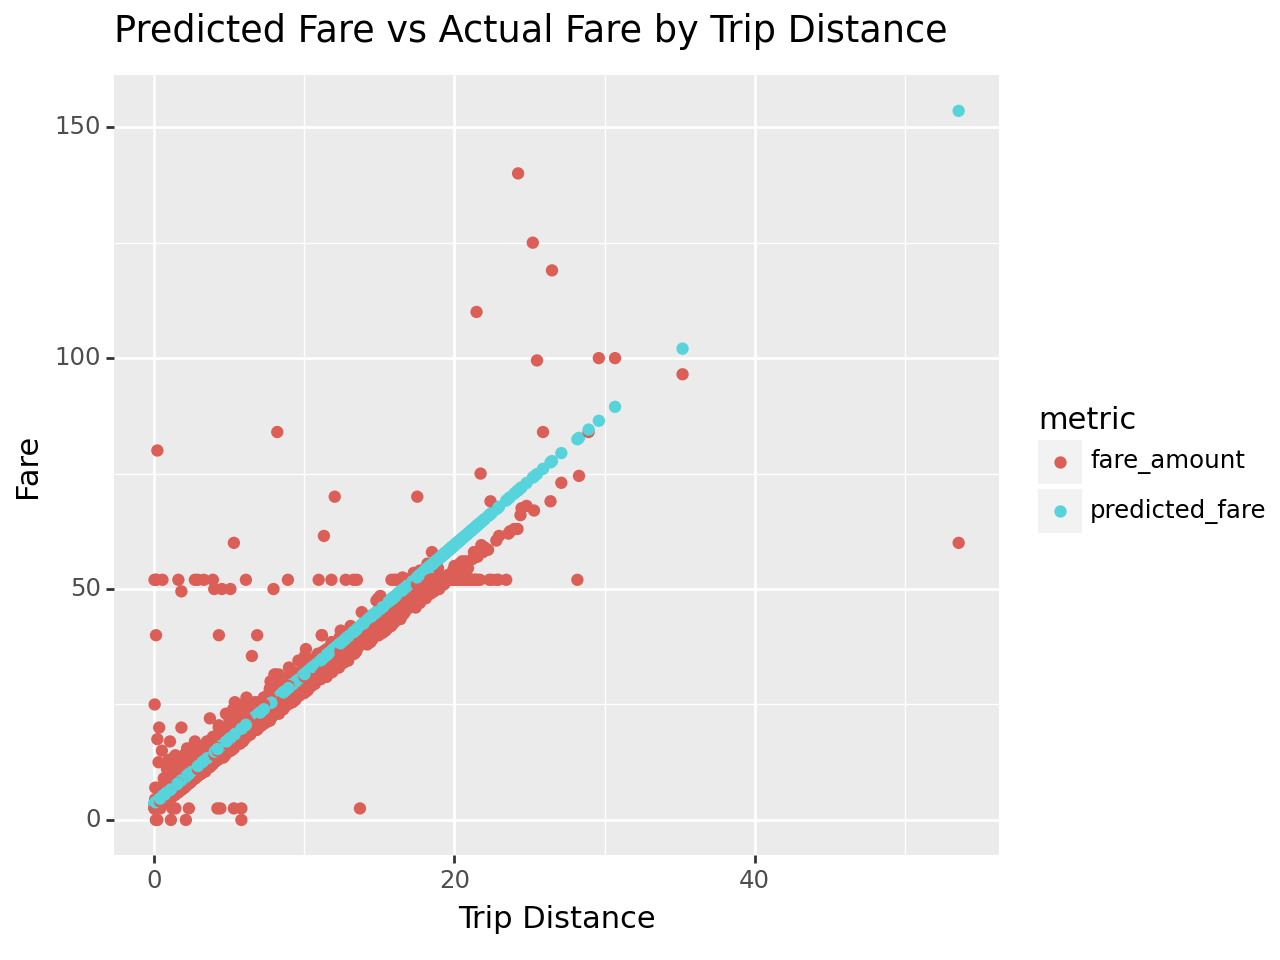

<Figure Size: (640 x 480)>

In [13]:
from plotnine import aes, ggtitle, ggplot, geom_point, xlab, ylab

(
    ggplot(pivoted_prediction, aes(x="trip_distance", y="fare", color="metric"))
    + geom_point()
    + xlab("Trip Distance")
    + ylab("Fare")
    + ggtitle("Predicted Fare vs Actual Fare by Trip Distance")
)

# Appendix: `model.py`

In [14]:
%pycat model.py

"""
Linear regiression model for predicting cab fares using PyTorch.

Adapted from https://gist.github.com/pdet/e8d38734232c08e6c15aba79b4eb8368#file-taxi_prediction_example-py.
"""

import pyarrow as pa
import torch
import tqdm
from torch import nn


class LinearRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, distances):
        return self.linear(distances)


class PredictCabFare:
    def __init__(self, data, learning_rate: float = 0.01, epochs: int = 100) -> None:
        # Define the input and output dimensions
        input_dim = 1
        output_dim = 1

        # Create a linear regression model instance
        self.data = data
        self.model = LinearRegression(input_dim, output_dim)
        self.learning_rate = learning_rate
        self.epochs = epochs

    def train(self):
        distances = self.data["trip_distance"].reshape(-1, 1)
        fare